Get necessary modules, and define constants

In [2]:
import os, cv2, sys, time
import numpy as np
from scipy import sqrt, pi, arctan2, cos, sin
from scipy.ndimage import uniform_filter
from sklearn import svm, metrics, tree, ensemble, linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from random import shuffle

# The dimensions to resize video frames to before calculating HoF
FIXED_WIDTH = 128
FIXED_HEIGHT = 128

# Property useful for finding length (in frames) of a video.
# Renamed here because the way to access it can differ between machines, so we can change it easily
FRAME_LENGTH_PROP = cv2.CAP_PROP_FRAME_COUNT

# Threshold ratio for segmentation. Segments longer than this * length of smallest video are not discarded
SEG_THRESHOLD = 0.5

# level parameter for pyramiDEBUG_COLLECTABLE | DEBUG_UNCOLLECTABLE | DEBUG_INSTANCES | DEBUG_OBJECTSding HoF
LEVEL = 3

# name of the dataset used
DATASET = "KTH"

Do some setup necessary for all/most descriptors

In [3]:
# Directory and files of the first action
ACT1_DIR = "./hof2/running/"
ACT1_FILES = os.listdir(ACT1_DIR)
ACT1_FILES = [ACT1_DIR + f for f in ACT1_FILES]

# Directory and files of the second action
ACT2_DIR = "./hof2/handclapping/"
ACT2_FILES = os.listdir(ACT2_DIR)
ACT2_FILES = [ACT2_DIR + f for f in ACT2_FILES]

# Directory and files of the third action
ACT3_DIR = "./hof2/boxing/"
ACT3_FILES = os.listdir(ACT3_DIR)
ACT3_FILES = [ACT3_DIR + f for f in ACT3_FILES]

# Directory and files of the fourth action
ACT4_DIR = "./hof2/walking/"
ACT4_FILES = os.listdir(ACT4_DIR)
ACT4_FILES = [ACT4_DIR + f for f in ACT4_FILES]

# Directory and files of the fifth action
ACT5_DIR = "./hof2/handwaving/"
ACT5_FILES = os.listdir(ACT5_DIR)
ACT5_FILES = [ACT5_DIR + f for f in ACT5_FILES]

shuffle(ACT1_FILES)
shuffle(ACT2_FILES)
shuffle(ACT3_FILES)
shuffle(ACT4_FILES)
shuffle(ACT5_FILES)

# Use equal number of data from each class, setting a cap at a total of 464 files
#nc = min(len(ACT1_FILES), len(ACT2_FILES), len(ACT3_FILES), len(ACT4_FILES), len(ACT5_FILES))

# We'll actually define a set number here because of memory issues
nc = 8

print "nc:", nc
ACT1_FILES = ACT1_FILES[0:nc]
ACT2_FILES = ACT2_FILES[0:nc]
ACT3_FILES = ACT3_FILES[0:nc]
ACT4_FILES = ACT4_FILES[0:nc]
ACT5_FILES = ACT5_FILES[0:nc]

# Get training files for each action
train_files = ACT1_FILES[0:nc] + ACT2_FILES[0:nc] + ACT3_FILES[0:nc] + ACT4_FILES[0:nc] + ACT5_FILES[0:nc]


# Put the labels in vectors
train_labels = np.zeros(nc*5, int)
train_labels[0:nc] = 1
train_labels[nc:nc*2] = 2
train_labels[nc*2:nc*3] = 3
train_labels[nc*3:nc*4] = 4
train_labels[nc*4:nc*5] = 5

print "train files:", len(train_files)
print "train labels:", len(train_labels)

nc: 8
train files: 40
train labels: 40


Define a method and parameters for normalizing frames, by transforming them to fixed dimensions and putting them in grayscale

In [4]:
def normalizeFrame(frame_original):
    frame_gray = cv2.cvtColor(frame_original,cv2.COLOR_BGR2GRAY)
    frame_gray_resized = cv2.resize(frame_gray, (FIXED_WIDTH, FIXED_HEIGHT))
    return frame_gray_resized

Define optical flow for this project. Uses the Farneback method for calculation.

In [5]:
# Gets the optical flow [<dx,dy>] from two frames
def getOpticalFlow(imPrev, imNew):
    flow = cv2.calcOpticalFlowFarneback(imPrev, imNew, flow=None, pyr_scale=.5, levels=3, winsize=9, 
                                        iterations=1, poly_n=3, poly_sigma=1.1, 
                                        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    return flow

Define HoF, which takes as a parameter the optical flow between two frames

In [6]:
# Compute the Histogram of Optical Flow (HoF) from the given optical flow
def hof(flow, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(4, 3), normalise=False, motion_threshold=1.):
    flow = np.atleast_2d(flow)

    if flow.ndim < 3:
        raise ValueError("Requires dense flow in both directions")

    if normalise:
        flow = sqrt(flow)

    if flow.dtype.kind == 'u':
        flow = flow.astype('float')

    gx = np.zeros(flow.shape[:2])
    gy = np.zeros(flow.shape[:2])

    gx = flow[:,:,1]
    gy = flow[:,:,0]

    magnitude = sqrt(gx**2 + gy**2)
    orientation = arctan2(gy, gx) * (180 / pi) % 180

    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    n_cellsx = int(np.floor(sx // cx))
    n_cellsy = int(np.floor(sy // cy))

    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))
    subsample = np.index_exp[cy / 2:cy * n_cellsy:cy, cx / 2:cx * n_cellsx:cx]
    for i in range(orientations-1):
        temp_ori = np.where(orientation < 180 / orientations * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i,
                            temp_ori, -1)

        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)

    temp_filt = uniform_filter(temp_mag, size=(cy, cx))
    orientation_histogram[:, :, -1] = temp_filt[subsample]

    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    normalised_blocks = np.zeros((n_blocksy, n_blocksx,
                                  by, bx, orientations))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / sqrt(block.sum()**2 + eps)

    return normalised_blocks.ravel()

Define a method for calculating HoF between two frames

In [7]:
# get the Histogram of Optical Flow from two images
def getHoF(frame1, frame2):
    flow = getOpticalFlow(frame1, frame2)
    return hof(flow, pixels_per_cell=(20,20), cells_per_block=(5,5))

And another for calculating the HoF feature vector for an entire video

In [8]:
# get the Histogram of Optical Flows of a video grouped sequentially in a 1D array
def getSequentialHoF(video_path):
    hofs = []
    cap = cv2.VideoCapture(video_path)
    ret1, frame1 = cap.read()
    frame1 = normalizeFrame(frame1)
    while(cap.isOpened()):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrame(frame2)
            hof_array = getHoF(frame1, frame2)
            hofs = np.concatenate((hofs, hof_array),axis=0)
            frame1 = frame2
        else:
            break
    return hofs

So far, we have all the methods necessary for a base HoF descriptor; however, having training/testing videos of different lengths means our feature vectors will have different lengths (not good for classifiers).

One approach to remedy this is to pad shorter vectors with zeros to the length of the largest vector. We define two methods to help us with this:

In [9]:
# Find the length of the largest row in training set and testing set
def maxRow(train):
    return np.array([len(i) for i in train]).max()

# Pad each row of the 2D array, with 0, to a specified width
def numpy_fillna(data, width):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(width) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out

def fillna(data, width):
    return [np.pad(d, (int(np.ceil((width-len(d))/2.)),int(np.floor((width-len(d))/2.))), mode="symmetric") for d in data]

Finally, we define a method which gets all the feature vectors we need, ensuring they are padded to the right length

In [10]:
def getFeatures_Baseline(train_files, train_labels):
    # Make feature vectors
    train = [getSequentialHoF(p) for p in train_files]

    # Pad them to the max video width
    max_width = maxRow(train)#, train);
    train_pad = fillna(np.array(train), max_width)

    return train_pad, train_labels

def getFeatures_Baseline_original(train_files, train_labels):
    # Make feature vectors
    train = [getSequentialHoF(p) for p in train_files]

    # Pad them to the max video width
    max_width = maxRow(train)#, train);
    train_pad = numpy_fillna(np.array(train), max_width)

    return train_pad, train_labels

This approach works, but may not give us the best accuracy since it introduces noise, especially for shorter videos. A different approach we take is to trim the videos to the length of the smallest video and then apply HoF, using frames only from the middle of each video.

We define a method to find the length of the shortest video in the video directory

In [11]:
# Determine the length in frames of the shortest video in the provided dataset
def shortest(data_dir):
    # get list of files in the directory. directory should be flat with only video files in it
    files = os.listdir(data_dir)

    # Find the length of the shortest video (in frames)
    shortestLen = sys.maxint
    for i in range(len(files)):
        cap = cv2.VideoCapture(data_dir+files[i])
        length = int(cap.get(FRAME_LENGTH_PROP))
        if length < shortestLen:
            shortestLen = length

        cap.release()

    return shortestLen

And a method which gets the HoF feature vector from the middle of a video, using the amount of frames determined by the above method (passed as param). This is the same as the base sequential HoF method, modified to get frames from the middle.

In [12]:
# Get the Histogram of Optical Flows of a video grouped sequentially in a 1D array
# Use only the specified amount of frames, from the middle of the video
def getSequentialHoFMiddle(video_path, frames):
    hofs = []
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(FRAME_LENGTH_PROP))
    startIdx = ((length - 1) - frames)/2
    if startIdx < 1:
        startIdx = 0
        
    # skip through beginning unneeded frames
    frameNum = 0
    while (frameNum < startIdx):
        cap.grab()
        frameNum += 1
    frameNum = 0
    
    # Calculate HoF from necessary frames
    ret1, frame1 = cap.read()
    frame1 = normalizeFrame(frame1)
    while(frameNum < frames-2):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrame(frame2)
            hof_array = getHoF(frame1, frame2)
            hofs = np.concatenate((hofs, hof_array),axis=0)
            frame1 = frame2
            frameNum += 1
        else:
            break
    
    cap.release()
    return hofs

Finally, we define a method which gets all the feature vectors we need, ensuring they are made from trimmed video middles

In [13]:
def getFeatures_Trimmed(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train = [getSequentialHoFMiddle(p, numFrames) for p in train_files]

    return np.array(train), train_labels

This gives us feature vectors with less noise than the baseline method, but can also eliminate a lot of useful information from longer videos. Another method which preserves most of this information while also ensuring uniform-length vectors, is to break each video into fixed-length segments, where each segment is the length of the shortest video in the set.

We define another method for calculating HoF feature vectors on each segment of a video.

In [14]:
def getSequentialHoFSegments(video_path, label, frames):
    seg_hofs = []
    hofs = []
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(FRAME_LENGTH_PROP))
    
    ret1, frame1 = cap.read()
    frame1 = normalizeFrame(frame1)
    while(cap.isOpened()):
        hofs = []
        for i in range(frames-1):
            ret2, frame2 = cap.read()
            if ret2 == True:
                frame2 = normalizeFrame(frame2)
                hof_array = getHoF(frame1, frame2)
                hofs = np.concatenate((hofs, hof_array),axis=0)
                frame1 = frame2
            else:
                cap.release()
                break
        seg_hofs.append(hofs)
    
    seg_labels = np.full(len(seg_hofs), label)
    return seg_hofs, seg_labels

The above method can produce one segment per video which is shorter than the minimum length (from the end). We could pad these, but for short segments this would introduce a lot of noise. We define a threshold (is a constant defined at top) length for these videos, pad those above the threshold, and discard segments which are too short.

In [15]:
def getFeatures_Segmented(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train_result = [a for t,l in zip(train_files, train_labels) for a in getSequentialHoFSegments(t, l, numFrames)]
    train = [y for x in train_result[::2] for y in x]
    new_train_labels = np.concatenate(train_result[1::2])
    train_threshold = int(max([len(x) for x in train]) * SEG_THRESHOLD)
    train_trimmed = [x for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    train_labels_trimmed = [y for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    max_width = np.array([len(i) for i in train_trimmed]).max()
    train_pad = fillna(np.array(train_trimmed), max_width)

    return train_pad, train_labels_trimmed

def getFeatures_Segmented_original(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train_result = [a for t,l in zip(train_files, train_labels) for a in getSequentialHoFSegments(t, l, numFrames)]
    train = [y for x in train_result[::2] for y in x]
    new_train_labels = np.concatenate(train_result[1::2])
    train_threshold = int(max([len(x) for x in train]) * SEG_THRESHOLD)
    train_trimmed = [x for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    train_labels_trimmed = [y for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    max_width = np.array([len(i) for i in train_trimmed]).max()
    train_pad = numpy_fillna(np.array(train_trimmed), max_width)

    return train_pad, train_labels_trimmed

We've now defined how to get features for HoF, using the padding, trimming, and segmentation methods of ensuring feature vectors are the same shape. Additionally, we want to make HoF feature vectors which use gaussian pyramiding in order to help reduce noise factors in videos.

Define a method for getting a pyramid for an image

In [16]:
def getPyramid(img, level):
    p = []
    p.append(img)
    for i in range(level):
        p.append(cv2.pyrDown(p[len(p)-1]))
    return p

Define a method for getting pyramid HoF between two frames

In [17]:
def pyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc):
    if frame1.shape != frame2.shape:
        raise ValueError('frame1 and frame2 should have identical dimensions')
    pyramid1 = getPyramidFunc(frame1, level)
    pyramid2 = getPyramidFunc(frame2, level)
    pyramidHoF = []
    for i in range(level):
        subframe1 = pyramid1[i]
        subframe2 = pyramid2[i]
        subflow = getOpticalFlowFunc(subframe1, subframe2)
        subhof = getHofFunc(subflow)
        pyramidHoF = np.append(pyramidHoF, subhof)
    return pyramidHoF

Define a method for determining pyramid HoF on whole video

In [18]:
def getPyramidHof(video_path, level, normalizeFrameFunc=normalizeFrame, getHofFunc=hof, getPyramidFunc=getPyramid, getOpticalFlowFunc=getOpticalFlow):
    cap = cv2.VideoCapture(video_path)
    vid_hof = []
    ret1, frame1 = cap.read()
    frame1 = normalizeFrameFunc(frame1)
    while(cap.isOpened()):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrameFunc(frame2)
            biframe_hof = pyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc)
            vid_hof = np.append(vid_hof, biframe_hof)
            frame1 = frame2
        else:
            break
    cap.release()
    return vid_hof

Define a method for getting pyramid HoF feature vectors

In [19]:
def getFeatures_Pyramid_Baseline(train_files, train_labels):
    # make feature vectors
    train = [getPyramidHof(p, LEVEL) for p in train_files]

    # Pad them to the max video width
    max_width = maxRow(train)
    train_pad = fillna(np.array(train), max_width)

    return train_pad, train_labels

def getFeatures_Pyramid_Baseline_original(train_files, train_labels):
    # make feature vectors
    train = [getPyramidHof(p, LEVEL) for p in train_files]

    # Pad them to the max video width
    max_width = maxRow(train)
    train_pad = numpy_fillna(np.array(train), max_width)

    return train_pad, train_labels

Now we want to repeat what we did before with trimming for pyramid HoF

In [20]:
def getPyramidHofMiddle(video_path, frames, level, normalizeFrameFunc=normalizeFrame, getHofFunc=hof, getPyramidFunc=getPyramid, getOpticalFlowFunc=getOpticalFlow):
    cap = cv2.VideoCapture(video_path)
    vid_hof = []
    
    length = int(cap.get(FRAME_LENGTH_PROP))
    startIdx = ((length - 1) - frames)/2
    if startIdx < 1:
        startIdx = 0
    # skip through beginning unneeded frames
    frameNum = 0
    while (frameNum < startIdx):
        cap.grab()
        frameNum += 1
    frameNum = 0
    
    ret1, frame1 = cap.read()
    frame1 = normalizeFrameFunc(frame1)
    while(frameNum < frames-2):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrameFunc(frame2)
            biframe_hof = pyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc)
            vid_hof = np.append(vid_hof, biframe_hof)
            frame1 = frame2
            frameNum += 1
        else:
            break
    cap.release()
    return vid_hof

def getFeatures_Pyramid_Trimmed(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train = [getPyramidHofMiddle(p, numFrames, LEVEL) for p in train_files]

    return np.array(train), train_labels

...As well as for segmentation

In [21]:
def getPyramidHoFSegments(video_path, label, frames, level, normalizeFrameFunc=normalizeFrame, getHofFunc=hof, getPyramidFunc=getPyramid, getOpticalFlowFunc=getOpticalFlow):
    seg_hofs = []
    hofs = []
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(FRAME_LENGTH_PROP))
    
    ret1, frame1 = cap.read()
    frame1 = normalizeFrame(frame1)
    while(cap.isOpened()):
        hofs = []
        for i in range(frames-1):
            ret2, frame2 = cap.read()
            if ret2 == True:
                frame2 = normalizeFrameFunc(frame2)
                biframe_hof = pyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc)
                hofs = np.concatenate((hofs, biframe_hof),axis=0)
                frame1 = frame2
            else:
                cap.release()
                break
        seg_hofs.append(hofs)
    
    seg_labels = np.full(len(seg_hofs), label)
    return seg_hofs, seg_labels

def getFeatures_Pyramid_Segmented(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train_result = [a for t,l in zip(train_files, train_labels) for a in getPyramidHoFSegments(t, l, numFrames, LEVEL)]
    train = [y for x in train_result[::2] for y in x]
    new_train_labels = np.concatenate(train_result[1::2])
    train_threshold = int(max([len(x) for x in train]) * SEG_THRESHOLD)
    train_trimmed = [x for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    train_labels_trimmed = [y for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    max_width = np.array([len(i) for i in train_trimmed]).max()
    train_pad = fillna(np.array(train_trimmed), max_width)

    return train_pad, train_labels_trimmed

def getFeatures_Pyramid_Segmented_original(train_files, train_labels):
    numFrames = min(shortest(ACT1_DIR), shortest(ACT2_DIR))
    train_result = [a for t,l in zip(train_files, train_labels) for a in getPyramidHoFSegments(t, l, numFrames, LEVEL)]
    train = [y for x in train_result[::2] for y in x]
    new_train_labels = np.concatenate(train_result[1::2])
    train_threshold = int(max([len(x) for x in train]) * SEG_THRESHOLD)
    train_trimmed = [x for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    train_labels_trimmed = [y for x,y in zip(train,new_train_labels) if len(x) > train_threshold]
    max_width = np.array([len(i) for i in train_trimmed]).max()
    train_pad = numpy_fillna(np.array(train_trimmed), max_width)

    return train_pad, train_labels_trimmed

Now, we are ready to train and evaluate models. Define method for training models given featuresets

In [22]:
def eval_model(featureGen, classifier, (data, labels)):
    clf = None
    name = ""
    if (classifier == 0):
        clf = svm.SVC()
        name = "SVM"
    elif (classifier == 1):
        clf = tree.DecisionTreeClassifier()
        name = "Decision-Tree"
    elif (classifier == 2):
        clf = ensemble.RandomForestClassifier()
        name = "Random-Forest"
    else:
        clf = linear_model.LogisticRegression()
        name = "Logistic-Regression"
        
    cross = cross_val_predict(clf, data, labels, cv=5)
    cm = confusion_matrix(labels, cross)
    fig = plt.figure()
    plt.matshow(cm)
    plt.title('CM for ' + featureGen + ", " + name)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('plots/'+DATASET+'_CM_'+featureGen+'_'+name+'.jpg')
    plt.show()
    score = metrics.accuracy_score(labels, cross)

    return score, name

def run(featureGen, data):
    for i in range(4):
        score, name = eval_model(featureGen, i, data);
        line = name + ": %0.2f" % score
        print(line)

Use python processify gist provided at https://gist.github.com/schlamar/2311116 to assist with memory management (we are having issues with the garbage collector)

In [23]:
import traceback
from functools import wraps
from multiprocessing import Process, Queue

def processify(func):
    '''Decorator to run a function as a process.
    Be sure that every argument and the return value
    is *pickable*.
    The created process is joined, so the code does not
    run in parallel.
    '''

    def process_func(q, *args, **kwargs):
        try:
            ret = func(*args, **kwargs)
        except Exception:
            ex_type, ex_value, tb = sys.exc_info()
            error = ex_type, ex_value, ''.join(traceback.format_tb(tb))
            ret = None
        else:
            error = None

        q.put((ret, error))

    # register original function with different name
    # in sys.modules so it is pickable
    process_func.__name__ = func.__name__ + 'processify_func'
    setattr(sys.modules[__name__], process_func.__name__, process_func)

    @wraps(func)
    def wrapper(*args, **kwargs):
        q = Queue()
        p = Process(target=process_func, args=[q] + list(args), kwargs=kwargs)
        p.start()
        ret, error = q.get()
        p.join()

        if error:
            ex_type, ex_value, tb_str = error
            message = '%s (in subprocess)\n%s' % (ex_value.message, tb_str)
            raise ex_type(message)

        return ret
    return wrapper

Test base HoF with padding

SVM: 0.57


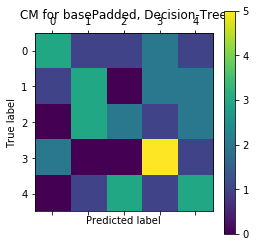

Decision-Tree: 0.40


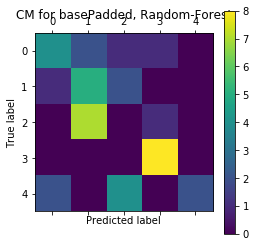

Random-Forest: 0.47


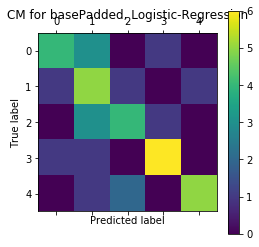

Logistic-Regression: 0.60


In [23]:
@processify
def basePadded():
    line = "basePadded"
    data = getFeatures_Baseline(train_files, train_labels)
    run(line, data)

basePadded()

Test base HoF with trimming

SVM: 0.62


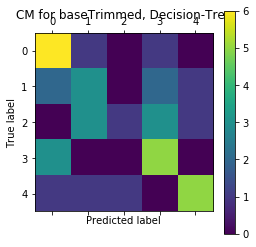

Decision-Tree: 0.50


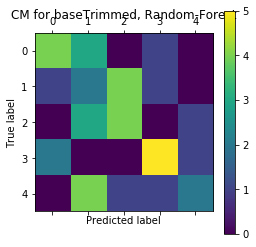

Random-Forest: 0.42


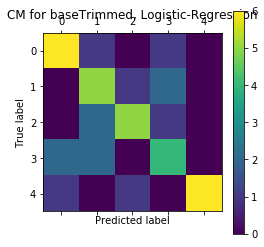

Logistic-Regression: 0.65


In [24]:
@processify
def baseTrimmed():
    line = "baseTrimmed"
    data = getFeatures_Trimmed(train_files, train_labels)
    run(line, data)
    
baseTrimmed()

Test base HoF with segmentation

SVM: 0.27


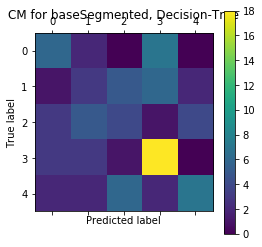

Decision-Tree: 0.41


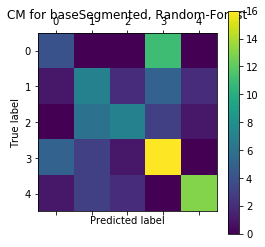

Random-Forest: 0.51


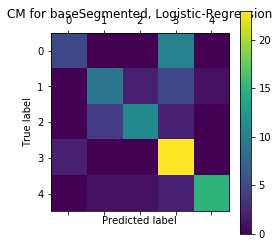

Logistic-Regression: 0.68


In [25]:
@processify
def baseSegmented():
    line = "baseSegmented"
    data = getFeatures_Segmented(train_files, train_labels)
    run(line, data)
    
baseSegmented()

Test pyramid HoF with padding

did the thing


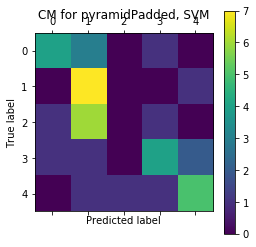

SVM: 0.50


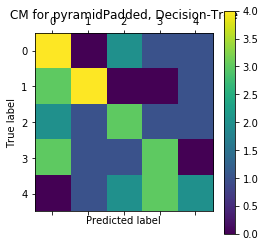

Decision-Tree: 0.40


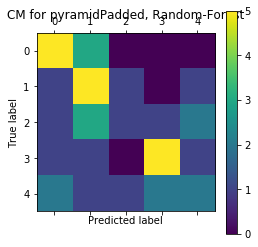

Random-Forest: 0.45


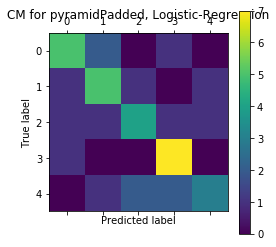

Logistic-Regression: 0.60


In [26]:
@processify
def pyrPadded():
    line = "pyramidPadded"
    data = getFeatures_Pyramid_Baseline(train_files, train_labels)
    print ("did the thing")
    time.sleep(30)
    run(line, data)
    
pyrPadded()

test pyramid HoF with trimming

SVM: 0.60


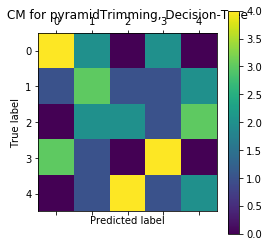

Decision-Tree: 0.38


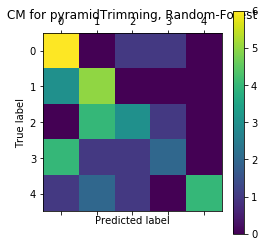

Random-Forest: 0.50


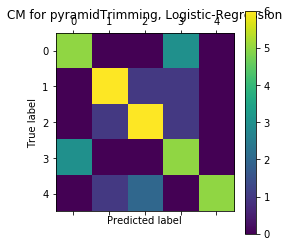

Logistic-Regression: 0.68


In [27]:
@processify
def pyrTrimmed():
    line = "pyramidTrimming"
    data = getFeatures_Pyramid_Trimmed(train_files, train_labels)
    run(line, data)
    
pyrTrimmed()

test pyramid HoF with segmentation

SVM: 0.27


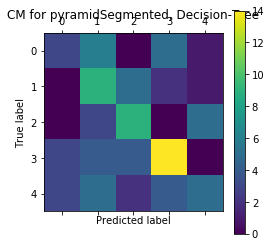

Decision-Tree: 0.43


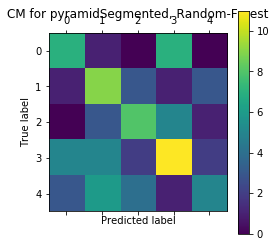

Random-Forest: 0.43


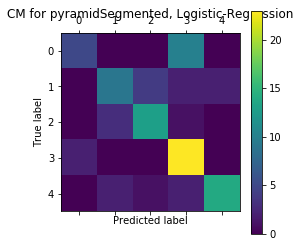

Logistic-Regression: 0.69


In [28]:
@processify
def pyrSegmented():
    line = "pyramidSegmented"
    data = getFeatures_Pyramid_Segmented(train_files, train_labels)
    run(line, data)
    
pyrSegmented()

Baseline with original padding method

SVM: 0.55


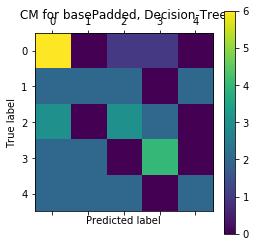

Decision-Tree: 0.42


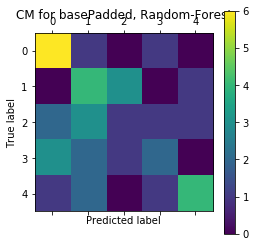

Random-Forest: 0.42


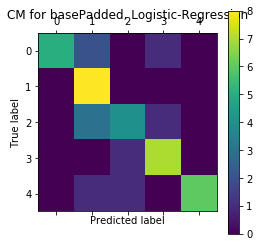

Logistic-Regression: 0.75


In [45]:
@processify
def basePadded_original():
    line = "basePadded"
    data = getFeatures_Baseline_original(train_files, train_labels)
    run(line, data)

basePadded_original()

Baseline with original padding method

SVM: 0.27


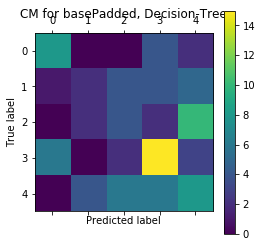

Decision-Tree: 0.38


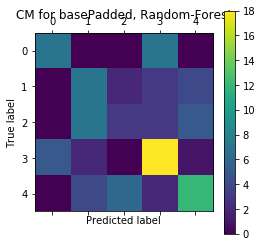

Random-Forest: 0.48


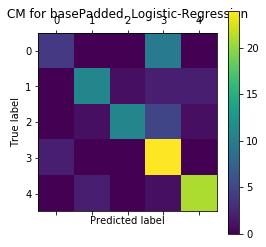

Logistic-Regression: 0.72


In [46]:
@processify
def baseSegmented_original():
    line = "basePadded"
    data = getFeatures_Segmented_original(train_files, train_labels)
    run(line, data)

baseSegmented_original()

Baseline with original padding method

SVM: 0.42


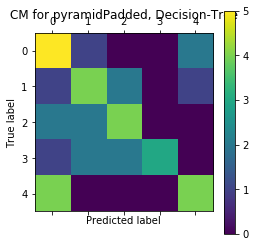

Decision-Tree: 0.50


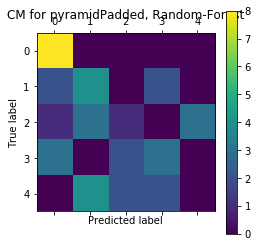

Random-Forest: 0.40


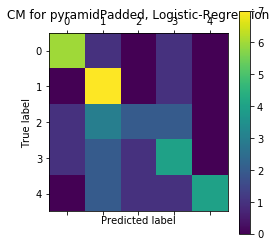

Logistic-Regression: 0.57


In [24]:
@processify
def pyrPadded_original():
    line = "pyramidPadded"
    data = getFeatures_Pyramid_Baseline_original(train_files, train_labels)
    run(line, data)
    
pyrPadded_original()

Baseline with original padding method

SVM: 0.23


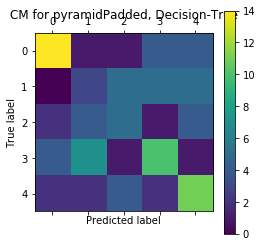

Decision-Tree: 0.42


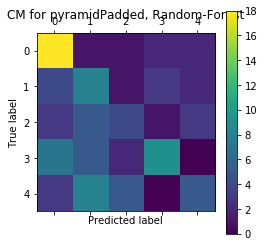

Random-Forest: 0.43


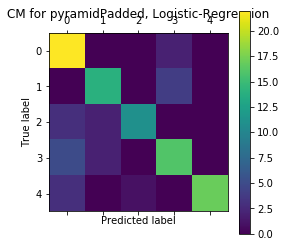

Logistic-Regression: 0.78


In [25]:
@processify
def pyrSegmented_original():
    line = "pyramidPadded"
    data = getFeatures_Pyramid_Segmented_original(train_files, train_labels)
    run(line, data)
    
pyrSegmented_original()